# Churn Analysis

## Imports

In [1]:
import pandas as pd #leitura do arquivo e transformações para data frame
import seaborn as sbn #plotagem da matriz de confusão
import statistics as sts #calculos de mediana
import matplotlib.pyplot as plt #plotar gráfico, boxplot e histograma
from sklearn.preprocessing import OneHotEncoder, StandardScaler #Enconding dos dados e padronização
from sklearn.compose import make_column_transformer #Encoding dos dados
from sklearn.model_selection import train_test_split #Divisão dos dados em treino e teste
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score #Métricas para avaliação do modelo
import numpy as np #Verificar o balanceamento da classe
from imblearn.under_sampling import RandomUnderSampler #Balanceamento da classe
from keras.models import Sequential #Criação do modelo
from keras.layers import Dense, Dropout #Criação do modelo
import pickle #Salvar o modelo

## Carregamento dos dados

Primeiramente, lemos o arquivo csv e renomeamos as colunas para pt-br
##### Arquivo retirado do Kaggle

In [2]:
dataset = pd.read_csv("Churn_Modelling.csv", sep=",")
colunas = ["n°Linha","ID","Sobrenome","Pontos","País","Gênero","Idade","TempoDaConta","Balanço","n°deProdutos","Cartão?","MembroAtivo?","Salário","Saiu"]
dataset.columns = colunas
dataset

,n°Linha,ID,Sobrenome,Pontos,País,Gênero,Idade,TempoDaConta,Balanço,n°deProdutos,Cartão?,MembroAtivo?,Salário,Saiu
0,1,15634602,Hargrave,619,NaN,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9998,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9999,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
10000,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Exploração e limpeza dos dados

Verificamos se há algum dado nulo

In [3]:
for i in range (dataset.shape[1]):
    a = dataset[dataset.columns[i]].isnull().sum()
    print(f"{colunas[i]}: {a}")

n°Linha: 0
ID: 0
Sobrenome: 0
Pontos: 0
País: 4
Gênero: 0
Idade: 0
TempoDaConta: 0
Balanço: 0
n°deProdutos: 0
Cartão?: 0
MembroAtivo?: 0
Salário: 0
Saiu: 0


##### Em "País" podemos ver que há 4 valores nulos

Como existe a coluna ID no dataset, conferimos se há algum duplicado

In [4]:
dataset[dataset.duplicated(["ID"], keep = False)]

,n°Linha,ID,Sobrenome,Pontos,País,Gênero,Idade,TempoDaConta,Balanço,n°deProdutos,Cartão?,MembroAtivo?,Salário,Saiu
104,105,15804919,Dunbabin,670,Spain,Female,65,1,0.00,1,1,1,177655.68,1
105,105,15804919,Dunbabin,670,Spain,Female,65,1,0.00,1,1,1,177655.68,1
2821,2821,15813916,Kudryashova,622,France,Female,31,1,89688.94,1,1,1,152305.47,0
2822,2821,15813916,Kudryashova,622,France,Female,31,1,89688.94,1,1,1,152305.47,0


##### O ID 105 e 2821 estão duplicados como mostra acima

##### Antes de continuarmos a exploração dos dados, vamos excluir a linha duplicado e as colunas que não serão utéis para o modelo, como: ID, n°Linha, Sobrenome

In [5]:
dataset.drop_duplicates(subset="ID", keep='first',inplace=True)
dataset.drop(columns=["n°Linha","ID","Sobrenome"], inplace = True)

Verificando se há categorias fora do escopo ou escritas de formas diferentes com o mesmo significado

In [6]:
colstring = dataset.select_dtypes(exclude='number')
for i in range (colstring.shape[1]):
    a = dataset.groupby([colstring.columns[i]]).size()
    print(f"{a}\n")

País
France     5010
Germany    2509
Spain      2477
dtype: int64

Gênero
F            3
Female    4540
M            2
Male      5455
dtype: int64



##### Em "Gênero" há as categorias M e F que tem o mesmo significado de Male e Female

Verificando se nas colunas numéricas existem valores fora do escopo ou outliers

In [7]:
colnumber = dataset.select_dtypes(include='number')
for i in range (colnumber.shape[1]):
    a = dataset[colnumber.columns[i]].describe()
    print(f"{a}\n")

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: Pontos, dtype: float64

count    10000.000000
mean        38.944500
std         10.644856
min         12.000000
25%         32.000000
50%         37.000000
75%         44.000000
max        200.000000
Name: Idade, dtype: float64

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: TempoDaConta, dtype: float64

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balanço, dtype: float64

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max     

##### Em "idade" o valor mínimo está 12 e o máximo 200, claramente fora do escopo
##### Em "salário" as métricas estão um pouco estranhas então vamos plotar alguns gráficos para verificar se há outliers, e em "balanço" também

<Figure size 432x288 with 0 Axes>

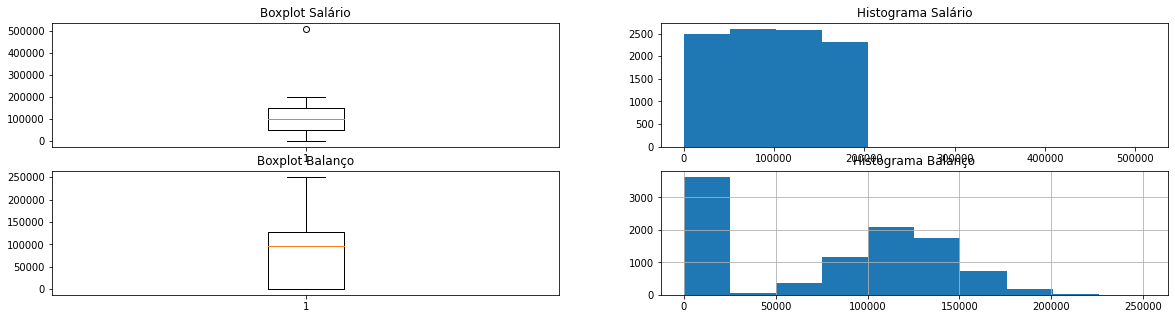

In [8]:
plt.figure()
plt.figure(figsize = (20,5))
plt.subplot(2,2,1)
plt.title("Boxplot Salário")
plt.boxplot(dataset["Salário"])
plt.subplot(2,2,2)
plt.title("Histograma Salário")
plt.hist(dataset["Salário"])
plt.subplot(2,2,3)
plt.title("Boxplot Balanço")
plt.boxplot(dataset["Balanço"])
plt.subplot(2,2,4)
plt.title("Histograma Balanço")
plt.hist(dataset["Balanço"])
plt.grid()

##### Através dos gráficos podemos ver que em "salário" há um outlier e que a maioria dos dados estão em torno de 0 e 200 mil. Em "balanço" não apresentou outliers

##### Com as observações que fizemos, podemos definir as seguintes limpezas a serem feitas:
* País -> preencher os valores nulos com a moda
* Gênero -> substiruir F e M por Female e Male
* Idade -> substituir as idade fora do escopo pela mediana(18 a 100 anos)
* Salário -> substituir os valores acima de 250 mil (outlier) pela mediana 

##### Optei pela substituição dos valores pela mediana ao invés da média, pois a mesma sofre menos influência dos outlier. 
##### Poderiamos também excluir as linhas com problemas, mas não quis reduzir a quantidade dos dados.

In [9]:
#Preenchimento dos valores nulos em "País"
dataset['País'].fillna("France", inplace=True)
dataset.groupby(['País']).size()

País
France     5014
Germany    2509
Spain      2477
dtype: int64

In [10]:
#Substituindo os valores M e F em Gênero
dataset.loc[dataset['Gênero'] ==  'M', 'Gênero'] = "Male"
dataset.loc[dataset['Gênero'].isin( ['Fem','F']), 'Gênero'] = "Female"
dataset.groupby(['Gênero']).size()

Gênero
Female    4543
Male      5457
dtype: int64

In [11]:
#Substitundo as idade fora do escopo
medianIdade = sts.median(dataset['Idade'])
dataset.loc[(dataset['Idade'] <  18 )  | ( dataset['Idade'] >  100), 'Idade'] = medianIdade
dataset.loc[(dataset['Idade'] <  18 )  | ( dataset['Idade'] >  100)]

,Pontos,País,Gênero,Idade,TempoDaConta,Balanço,n°deProdutos,Cartão?,MembroAtivo?,Salário,Saiu


In [12]:
#Substituindo valores outlier pelo salário mediano
medianSalario = sts.median(dataset['Salário'])
dataset.loc[dataset['Salário'] >=  250000, 'Salário'] = medianSalario
dataset.loc[dataset['Salário'] >=  250000]

,Pontos,País,Gênero,Idade,TempoDaConta,Balanço,n°deProdutos,Cartão?,MembroAtivo?,Salário,Saiu


Salvando o dataset já limpo e plotando para verificar como está

In [13]:
dataset.to_csv("Churn_limpo.csv", encoding='utf-8', index=False, sep = ";")
dataset

,Pontos,País,Gênero,Idade,TempoDaConta,Balanço,n°deProdutos,Cartão?,MembroAtivo?,Salário,Saiu
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9997,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9998,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9999,709,France,Female,36,7,0.00,1,0,1,42085.58,1
10000,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Preparação dos dados para a criação do modelo

Separação da classe das demais colunas

In [14]:
previsores = dataset.iloc[:,0:10].values
classe = dataset.iloc[:,10].values

Transformação dos dados categóricos em vetores binários com a técnica de One-Hot-Encoding
##### O One Hot Encoding transforma as colunas categorica em uma variável "dummy", o que gera uma multicolinearidade e torna os atributos altamente previsíveis, então para evitar a "dummy variable trap"  vamos excluir um dos atributos

In [15]:
onehotencoder = make_column_transformer((OneHotEncoder(categories='auto', sparse=False), [1]), remainder="passthrough")
previsores = onehotencoder.fit_transform(previsores)
previsores = previsores[:,1:] #Exclusão da coluna
onehotencoder = make_column_transformer((OneHotEncoder(categories='auto', sparse=False), [3]), remainder="passthrough")
previsores = onehotencoder.fit_transform(previsores)
previsores = previsores[:,1:] #Exclusão da coluna
pd.DataFrame(previsores) #Visualização dos dados

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,619,42,2,0.0,1,1,1,101348.88
1,0.0,0.0,1.0,608,41,1,83807.86,1,0,1,112542.58
2,0.0,0.0,0.0,502,42,8,159660.8,3,1,0,113931.57
3,0.0,0.0,0.0,699,39,1,0.0,2,0,0,93826.63
4,0.0,0.0,1.0,850,43,2,125510.82,1,1,1,79084.1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,771,39,5,0.0,2,1,0,96270.64
9996,1.0,0.0,0.0,516,35,10,57369.61,1,1,1,101699.77
9997,0.0,0.0,0.0,709,36,7,0.0,1,0,1,42085.58
9998,1.0,1.0,0.0,772,42,3,75075.31,2,1,0,92888.52


Verificamos o balanceamento da classe e fazemos um Under Samples (a técnica de Under sampling exclui aleatóriamente linhas da classe majoritária)
##### O balanceamente serve para que o algoritmo não crie uma tendência para a classe majoritária, consequentemente diminuindo o desempenho na hora de prever a classe minoritária ("Saiu")
##### Visto que com nossos dados pretendemos prever o Churn, Falsos Positivos (Previu que "Ficou", mas na realidade "Saiu") podem ser mais impactantes que Falsos Negativos

In [16]:
#Verificando o balanceamento da classe
np.bincount(classe)

array([7963, 2037], dtype=int64)

In [17]:
#Balanceando a classe
sm = RandomUnderSampler()
previsores, classe = sm.fit_resample(previsores, classe)

##### Padronização dos dados, para ficarem em uma escala próxima

In [18]:
sc = StandardScaler()
previsores = sc.fit_transform(previsores)

##### Separação dos dados em treino e teste para evitar o Overfitting

In [19]:
x_train, x_test, y_train, y_test = train_test_split(previsores, classe, test_size = 0.3)

## Criação do modelo

In [25]:
modelo = Sequential()
modelo.add(Dense(units = 6, activation = 'relu', input_dim = 11))
modelo.add(Dropout(0.2))
modelo.add(Dense(units = 6, activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(units = 1, activation = 'sigmoid'))

modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Treinando o modelo
modelo.fit(x_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
286/286 [==============================] - 1s 992us/step - loss: 0.7083 - accuracy: 0.5340
Epoch 2/100
286/286 [==============================] - 0s 1ms/step - loss: 0.6557 - accuracy: 0.6120
Epoch 3/100
286/286 [==============================] - 0s 918us/step - loss: 0.6614 - accuracy: 0.6027
Epoch 4/100
286/286 [==============================] - 0s 908us/step - loss: 0.6400 - accuracy: 0.6416
Epoch 5/100
286/286 [==============================] - 0s 901us/step - loss: 0.6354 - accuracy: 0.6587
Epoch 6/100
286/286 [==============================] - 0s 904us/step - loss: 0.6260 - accuracy: 0.6658
Epoch 7/100
286/286 [==============================] - 0s 901us/step - loss: 0.6119 - accuracy: 0.6713
Epoch 8/100
286/286 [==============================] - 0s 921us/step - loss: 0.6132 - accuracy: 0.6673
Epoch 9/100
286/286 [==============================] - 0s 1ms/step - loss: 0.6134 - accuracy: 0.6696
Epoch 10/100
286/286 [==============================] - 0s 1ms/step - loss: 0

Com o modelo criado, fazemos a previsão com os dados separados para teste

In [26]:
previsao = modelo.predict(x_test)

## Métricas de avaliação

As métricas que utilizaremos serão:
- Matriz de confusão
- Acerto (porcentagem geral de acerto)
- Recall (De todos os "Ficou/Saiu", quantos foram classificadas corretamente como "Ficou/Saiu"?)
- Precision (Dos que foram classificados como "Ficou/Saiu", quantos de fato eram "Ficou/Saiu"?)

In [27]:
previsao = (previsao > 0.5) #transforação dos dados para booleanos
confusao = confusion_matrix(previsao, y_test)
acerto = accuracy_score(previsao, y_test)
recall = recall_score(previsao, y_test, average = None)
precisao = precision_score(previsao, y_test, average = None)

In [28]:
#Organização dos dados em um DataFrame para plotagem
matriz = [["Acerto", acerto],
          ["Recall 'Ficou'",recall[0]],
          ["Recall 'Saiu'",recall[1]],
          ["Precisão 'Ficou'",precisao[0]],
          ["Precisão 'Saiu'",precisao[1]]]
matriz = pd.DataFrame(matriz,columns = ["Métricas","Valores"])

,Métricas,Valores
0,Acerto,0.771872
1,Recall 'Ficou',0.741935
2,Recall 'Saiu',0.805944
3,Precisão 'Ficou',0.813131
4,Precisão 'Saiu',0.732909


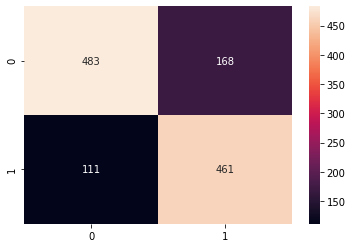

In [29]:
#Plotagem da matriz de confusão
sbn.heatmap(pd.DataFrame(confusao, columns = ["0","1"], index = ["0","1"]), annot=True, fmt="d")
matriz

#### Nosso modelo alcançou uma acertividade em torno de 76% nas métricas utilizadas, como consta nas matrizes geradas

Salvando o modelo

In [34]:
# serialize model to JSON
model_json = modelo.to_json()
with open("modelo.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelo.save_weights("modelo.h5")